In [1]:
pip install numpy pandas matplotlib yfinance scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [5]:
# Pick 5 Indian stocks (you can change later)
tickers = ['TCS.NS', 'INFY.NS', 'RELIANCE.NS', 'HDFCBANK.NS', 'ITC.NS']

# Download adjusted closing prices from Yahoo Finance
data = yf.download(tickers, start='2022-01-01', end='2023-12-31', auto_adjust=True)['Close']

# Show first 5 rows
data.head()

[*********************100%***********************]  5 of 5 completed


Ticker,HDFCBANK.NS,INFY.NS,ITC.NS,RELIANCE.NS,TCS.NS
Date,,,,,
2022-01-03,1449.202515,1755.068359,191.641891,1109.376343,3559.860840
2022-01-04,1457.689941,1755.715698,192.647736,1134.412720,3622.334717
2022-01-05,1492.307007,1705.331665,192.910156,1139.719971,3600.142334
2022-01-06,1468.370728,1680.509644,191.291977,1115.214355,3550.256348
2022-01-07,1478.670044,1677.274048,191.029572,1124.213623,3593.195312


In [6]:
# Calculate daily returns (percentage change)
returns = data.pct_change().dropna()
returns.head()


Ticker,HDFCBANK.NS,INFY.NS,ITC.NS,RELIANCE.NS,TCS.NS
Date,,,,,
2022-01-04,0.005857,0.000369,0.005249,0.022568,0.017550
2022-01-05,0.023748,-0.028697,0.001362,0.004678,-0.006127
2022-01-06,-0.016040,-0.014556,-0.008388,-0.021501,-0.013857
2022-01-07,0.007014,-0.001925,-0.001372,0.008070,0.012095
2022-01-10,0.005546,0.020090,0.022436,0.000821,0.006838


In [7]:
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free=0.06):
    returns = np.sum(mean_returns * weights) * 252  # 252 = trading days in a year
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = (returns - risk_free) / std_dev
    return returns, std_dev, sharpe_ratio


In [8]:
mean_returns = returns.mean()
cov_matrix = returns.cov()


In [11]:
def neg_sharpe(weights, mean_returns, cov_matrix, risk_free=0.06):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free)[2]

def optimize_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    
    # ✅ Constraint 1: Weights must sum to 1
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    
    # ✅ Constraint 2 (optional): Minimum and maximum weight (e.g., no more than 40% in one stock)
    bounds = tuple((0.05, 0.4) for _ in range(num_assets))  # You can tweak min/max

    result = minimize(
        neg_sharpe,
        num_assets * [1. / num_assets],
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return result



In [12]:
opt_result = optimize_portfolio(mean_returns, cov_matrix)
optimal_weights = opt_result.x

# Show the result clearly
for stock, weight in zip(tickers, optimal_weights):
    print(f"{stock}: {weight:.2%}")


TCS.NS: 27.89%
INFY.NS: 5.00%
RELIANCE.NS: 40.00%
HDFCBANK.NS: 22.11%
ITC.NS: 5.00%


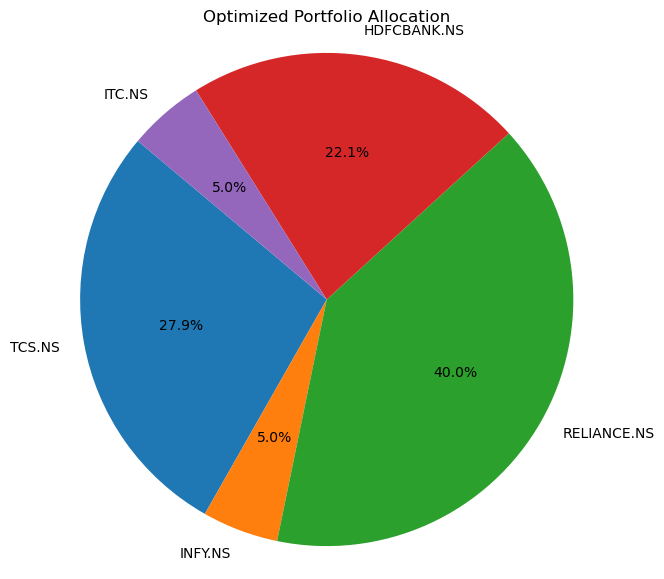

In [13]:
# Plot pie chart of stock allocations
plt.figure(figsize=(7, 7))
plt.pie(optimal_weights, labels=tickers, autopct='%1.1f%%', startangle=140)
plt.title("Optimized Portfolio Allocation")
plt.axis('equal')
plt.show()


In [14]:
ret, risk, sharpe = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
print(f"Expected Annual Return: {ret:.2%}")
print(f"Annual Volatility (Risk): {risk:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")


Expected Annual Return: 22.29%
Annual Volatility (Risk): 14.62%
Sharpe Ratio: 1.11
